# Recommender Systems

In this lab, we'll be using Keras to build a recommender system. We'll be using the MovieLens dataset, a common benchmark dataset for recommender systems. 

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. You can check out the website here: https://movielens.org/

We will download a subset of the dataset containing 100k ratings. There are tens of millions of ratings in the full dataset, spanning hundreds of thousands of users and movies. The subset we'll be using is a good example to demonstrate the concepts in this lab.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
from urllib.request import urlretrieve
from pathlib import Path

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = Path("ml-100k.zip")
ML_100K_FOLDER = Path("ml-100k")

if not ML_100K_FOLDER.exists():
    if not ML_100K_FILENAME.exists():
        urlretrieve(ML_100K_URL, ML_100K_FILENAME.name)
    with ZipFile(ML_100K_FILENAME.name) as zipf:
        zip.extractall()

The goal of MovieLens is to enable models to predict the rating a user would give to a movie they have not yet watched. This is a classic example of a recommendation system. The dataset is huge, and contains many parts giving information about the movies, the users, and the ratings. To begin with, we will look at the ratings file. Each line in the ratings file (u.data) is formatted as:

`user_id, item_id, rating, timestamp`

Which tells us a single user's rating of a single movie.

We will start by loading the ratings data into a pandas dataframe and then take a look at the first few rows. If you haven't used Pandas before, it's an extremely powerful library for dealing with tabular data. You can think of it as a Python version of Excel.

In [2]:
import pandas as pd

raw_ratings = pd.read_csv(ML_100K_FOLDER / "u.data", sep='\t',
                          names=["user_id", "item_id", "rating", "timestamp"])
raw_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


The second file we'll look at is the movie metadata. This file (u.item) contains information about each movie, including the title and release date. Each line in the file is formatted as:

`movie_id | movie_title | release_date | video_release_date | IMDb_URL | unknown | Action | Adventure | Animation | Children's | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western`

As you can see, the genres are binary variables. As with one-hot encoding, a 1 indicates that the movie is of that genre, and a 0 indicates that it is not. We aren't going to work with the genre data in this lab, but it's easy to imagine that it could be useful in a real-world recommendation system.

In [3]:
columns_to_keep = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(ML_100K_FOLDER / "u.item", sep='|', names=columns_to_keep,
                    encoding='latin-1', usecols=range(5))
items

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


By default, the `release_date` column is a string. We can convert it to a `datetime` object using the `pd.to_datetime` function. This will make it easier to work with in the future (if we want to do things like check which date came first, for example).
 
We can also extract the year from the date and store it in a separate column. This will make it easier to do things like plot the number of movies released each year.

In [4]:
items['release_date'] = pd.to_datetime(items['release_date']) # Pandas makes this easy!
items['release_year'] = items['release_date'].dt.year # For later use

For our purposes, it will be easier to work with the data if we merge our two dataframes into a single dataframe. We can do this using the `merge` method. We'll merge the `items` dataframe into the `raw_ratings` dataframe, using the `item_id` column as the key. This will add the movie title and release year to each rating.

In [5]:
all_ratings = pd.merge(items, raw_ratings)

In [6]:
all_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


### Data preprocessing

It's always important to understand the data you've collected. Thankfully, Pandas continues to make this easy for us. Using the `describe` method, we can get a quick statistical summary of the data.

In [7]:
all_ratings.describe()

,item_id,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,NaN,1987.956216,462.48475,3.529860,8.835289e+08
std,330.798356,NaN,14.155523,266.61442,1.125674,5.343856e+06
min,1.000000,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


Let's do a bit more pandas magic to compute the popularity of each movie (number of ratings). We will use the `groupby` method to group the dataframe by the `item_id` column and then use the `size` method to compute the number of ratings for each movie. We will use the `reset_index` method to convert the resulting Series into a dataframe with an `item_id` column.

In [8]:
popularity = all_ratings.groupby('item_id').size().reset_index(name='popularity')
items = pd.merge(popularity, items)

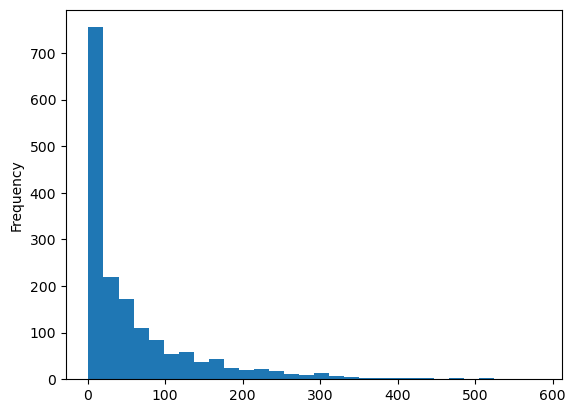

In [9]:
items['popularity'].plot.hist(bins=30);

In [10]:
(items['popularity'] == 1).sum() # Number of movies with only one rating

141

In [11]:
items.nlargest(10, 'popularity')['title'] # Get the 10 most popular movies

49                  Star Wars (1977)
257                   Contact (1997)
99                      Fargo (1996)
180        Return of the Jedi (1983)
293                 Liar Liar (1997)
285      English Patient, The (1996)
287                    Scream (1996)
0                   Toy Story (1995)
299             Air Force One (1997)
120    Independence Day (ID4) (1996)
Name: title, dtype: object

In [12]:
all_ratings = pd.merge(popularity, all_ratings)
all_ratings.describe()

,item_id,popularity,video_release_date,release_year,user_id,rating,timestamp
count,100000.000000,100000.000000,0.0,99991.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,168.071900,NaN,1987.956216,462.48475,3.529860,8.835289e+08
std,330.798356,121.784558,NaN,14.155523,266.61442,1.125674,5.343856e+06
min,1.000000,1.000000,NaN,1922.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,71.000000,NaN,1986.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,145.000000,NaN,1994.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,239.000000,NaN,1996.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,583.000000,NaN,1998.000000,943.00000,5.000000,8.932866e+08


In [13]:
indexed_items = items.set_index('item_id')

In [14]:
all_ratings.head()

,item_id,popularity,title,release_date,video_release_date,imdb_url,release_year,user_id,rating,timestamp
0,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,308,4,887736532
1,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,287,5,875334088
2,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,148,4,877019411
3,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,280,4,891700426
4,1,452,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995.0,66,3,883601324


---

**Quick Exercise**:

As we have seen, the `groupby` method is a powerful tool to quickly compute statistics on the data. Use it to compute the average rating for each movie.

**Hint**: you can use the `mean` method after the `groupby` method.

In [15]:
Movie_Average_Rating = all_ratings.groupby(['title', 'item_id', ])['rating'].mean()
Movie_Average_Rating

title                                  item_id
'Til There Was You (1997)              1300       2.333333
1-900 (1994)                           1353       2.600000
101 Dalmatians (1996)                  225        2.908257
12 Angry Men (1957)                    178        4.344000
187 (1997)                             330        3.024390
                                                    ...   
Young Guns II (1990)                   1188       2.772727
Young Poisoner's Handbook, The (1995)  547        3.341463
Zeus and Roxanne (1997)                1164       2.166667
unknown                                267        3.444444
Á köldum klaka (Cold Fever) (1994)     1633       3.000000
Name: rating, Length: 1682, dtype: float64

In [16]:
Movie_Average_Rating = all_ratings.groupby(['title', 'item_id'])['rating'].mean().reset_index(name='Average rating')
Movie_Average_Rating

,title,item_id,Average rating
0,'Til There Was You (1997),1300,2.333333
1,1-900 (1994),1353,2.600000
2,101 Dalmatians (1996),225,2.908257
3,12 Angry Men (1957),178,4.344000
4,187 (1997),330,3.024390
...,...,...,...
1677,Young Guns II (1990),1188,2.772727
1678,"Young Poisoner's Handbook, The (1995)",547,3.341463
1679,Zeus and Roxanne (1997),1164,2.166667
1680,unknown,267,3.444444


In [17]:
Movie_Average_Rating = Movie_Average_Rating.sort_values(by='Average rating', ascending=False)
Movie_Average_Rating

,title,item_id,Average rating
956,Marlene Dietrich: Shadow and Light (1996),1201,5.0
30,Aiqing wansui (1994),1536,5.0
1291,Santa with Muscles (1996),1500,5.0
1489,They Made Me a Criminal (1939),1122,5.0
641,"Great Day in Harlem, A (1994)",814,5.0
...,...,...,...
498,Falling in Love Again (1980),1374,1.0
103,August (1996),1325,1.0
963,Mat' i syn (1997),1678,1.0
490,"Eye of Vichy, The (Oeil de Vichy, L') (1993)",1562,1.0


---

Let's split the enriched data in a train / test split to make it possible to do predictive modeling:

In [18]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])

# Explicit feedback: supervised ratings prediction

Now let's begin to do some recommendation! We will build a model that takes a user and a movie as input and outputs a predicted rating. We will be taking advantage of embeddings to represent users and movies. That means that each movie and user will have an abstract representation in a continuous vector space. The model will learn these representations based on the ratings.

## Predictive ratings  as a regression problem

The following code implements the following architecture:

<img src="https://raw.githubusercontent.com/UofT-DSI/deep_learning/main/notebooks/images/rec_archi_1.svg" style="width: 600px;" />

In [19]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model

In [20]:
# For each sample we input the integer identifiers
# of a single user and a single item
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()
        
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')
        
        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)
        
    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]
        
        user_vecs = self.flatten(self.user_embedding(user_inputs))  # user vectors
        item_vecs = self.flatten(self.item_embedding(item_inputs))  # item vectors
        
        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

In [21]:
all_ratings['user_id'].max()

943

In [22]:
all_ratings['item_id'].max()

1682

### Monitoring runs

When training a model with Keras, we get a `history` object back that contains lots of information about the training run. We can use this to plot the training and validation loss to see how the model has improved during training.

In [23]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 2.6797 - val_loss: 1.0721
Epoch 2/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8586 - val_loss: 0.7954
Epoch 3/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7516 - val_loss: 0.7633
Epoch 4/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7183 - val_loss: 0.7529
Epoch 5/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6932 - val_loss: 0.7464
Epoch 6/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6695 - val_loss: 0.7409
Epoch 7/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6471 - val_loss: 0.7408
Epoch 8/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6243 - val_loss: 0.7402
Epoch 9/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6008 - val_loss: 0.7405
Epoch 10/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.577

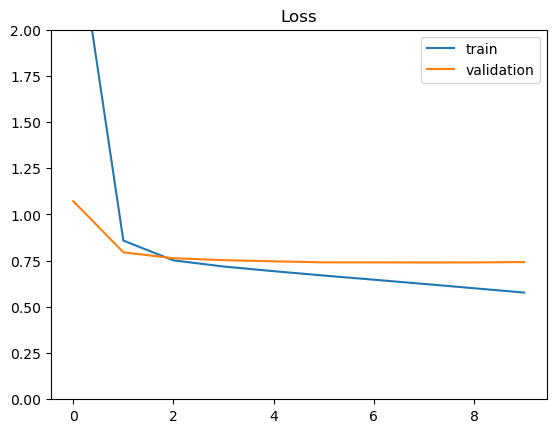

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

**Questions**:

- Does it look like our model has overfit? Why or why not?
- Suggest something we could do to prevent overfitting.


Now that the model is trained, let's check out the quality of predictions:

In [25]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

625/625 [==============================] - 1s 1ms/step
Final test MSE: 0.905
Final test MAE: 0.733


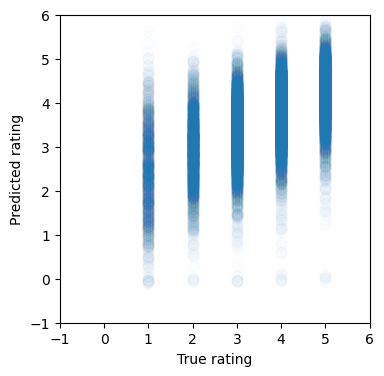

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

This graph shows us the range of predicted ratings our model gives, organized by the true rating. We can see that generally, the higher the true rating the higher the predicted rating, although there is quite a range of predictions for each instance. That's okay - our model is very simple, and human preferences are very complex!

Taking a look at the Mean Absolute Error, hopefully you got something around 0.75. This means that, on average, our predicted ratings are about 0.75 stars off from the true ratings. This is a pretty good result for a first attempt. We could probably do better with a more complex model, but we'll leave that for another time.

### Model Embeddings

Our model was built with two embedding layers. These layers have learned a representation of both the users and the movies in our dataset. We can extract these representations and use them to find similar movies or users. We can also do interesting exploratory analysis, like finding the most popular movies among our users, or finding the users that are most interested in a given movie.

In [27]:
# weights and shape
weights = model.get_weights()
[w.shape for w in weights]

[(944, 64), (1683, 64)]

In [28]:
user_embeddings = weights[0]
item_embeddings = weights[1]

In [29]:
item_id = 181
print(f"Title for item_id={item_id}: {indexed_items['title'][item_id]}")

Title for item_id=181: Return of the Jedi (1983)


In [30]:
print(f"Embedding vector for item_id={item_id}")
print(item_embeddings[item_id])
print("shape:", item_embeddings[item_id].shape)

Embedding vector for item_id=181
[ 0.18672383 -0.2978096  -0.40158215 -0.49843508 -0.39000568 -0.3664251
  0.18003385  0.27222267 -0.22322267 -0.34150067 -0.2877164   0.53453135
 -0.24238798  0.43675375  0.66620594  0.532929    0.12481023 -0.2747704
 -0.41265175  0.31664017  0.0804911   0.44490585  0.3000194   0.20994946
 -0.5264261  -0.4071337   0.529492   -0.13357806 -0.43033698 -0.43519706
 -0.26638147  0.40297052 -0.3451471   0.30936667 -0.00300939  0.20344467
 -0.08304933  0.2854312  -0.18346958 -0.8087031  -0.46078983  0.17942904
 -0.39518353  0.4665611  -0.27793148 -0.23309514 -0.2658991  -0.19765677
 -0.44535118 -0.4210544  -0.10648281 -0.5306849   0.20650697 -0.11345439
 -0.35706326 -0.1901029   0.20881501 -0.20659153  0.4706016  -0.18842532
  0.29729295  0.39881063  0.28715017  0.11522447]
shape: (64,)


As we discussed in lecture, our embeddings are not directly interpretable - we can't look at, say, a value of 0.297 in the embedding vector and say "this means that the movie is a drama". As an aside, there is a field of research dedicated to making _interpretable_ embeddings, but it's not something we'll cover in this course. 

### Finding our most similar items

Now we can have some fun, investigating the embeddings we've learned. We can start by finding the most similar items to a given item. We can do this by computing the cosine similarity between the item's embedding and the embedding of every other item. We can use the `cosine_similarity` function from `sklearn` to do this.

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine(a, b):
    # Reshape to the shape our function expects
    a = a.reshape(1, -1)
    b = b.reshape(1, -1)
    return cosine_similarity(a, b)[0, 0]

In [32]:
def print_similarity(item_a, item_b, item_embeddings, titles):
    print(titles[item_a])
    print(titles[item_b])
    similarity = cosine(item_embeddings[item_a],
                        item_embeddings[item_b])
    print(f"Cosine similarity: {similarity:.3}")
    
print_similarity(50, 181, item_embeddings, indexed_items["title"])

Star Wars (1977)
Return of the Jedi (1983)
Cosine similarity: 0.917


It makes sense that the original Star Wars, and its later sequel Return of the Jedi have a high similarity. Let's try some other examples:

In [33]:
print_similarity(181, 288, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Scream (1996)
Cosine similarity: 0.622


In [34]:
print_similarity(181, 1, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Toy Story (1995)
Cosine similarity: 0.827


In [35]:
print_similarity(181, 181, item_embeddings, indexed_items["title"])

Return of the Jedi (1983)
Return of the Jedi (1983)
Cosine similarity: 1.0


*Quick Exercise*:

- Find some other films and compare their similarity. Do the results make sense to you? Can you find a pair of films that are very _dissimilar_?

**Pair of films that are least similar**

In [36]:
import numpy as np

def find_least_similar_films(item_embeddings, titles):
    num_items = item_embeddings.shape[0]
    min_similarity = float('inf')  
    least_similar_pair = (None, None)  
    
    # Iterate over all pairs of films
    for i in range(num_items):
        for j in range(i + 1, num_items):  
            similarity = cosine(item_embeddings[i], item_embeddings[j])
            
            # Check if this pair is less similar
            if similarity < min_similarity:  
                min_similarity = similarity
                least_similar_pair = (i, j)
    
    # Extract the titles of the least similar pair
    film_a, film_b = least_similar_pair
    print(f"Least similar films:")
    print(f"{titles[film_a]} and {titles[film_b]}")
    print(f"Cosine similarity: {min_similarity:.3}")
    return film_a, film_b, min_similarity


least_similar = find_least_similar_films(item_embeddings, indexed_items["title"])


Least similar films:
Star Trek: Generations (1994) and Careful (1992)
Cosine similarity: -0.441


In [37]:
# Code to help you search for a movie title
partial_title = "Jedi"
indexed_items[indexed_items['title'].str.contains(partial_title)]

'''see above'''

'see above'

Sometimes, even without knowing anything about a user, we can recommend films by asking them about a film that they do like. The code below compares the similarity of a given film to all others, and returns the most similar films.

In [38]:
def most_similar(item_id, item_embeddings, titles,
                 top_n=30):
    # Compute the cosine similarity between the item and all other items
    sims = cosine_similarity(item_embeddings[item_id].reshape(1, -1),
                             item_embeddings).ravel()
    
    # [::-1] makes it possible to reverse the order of a numpy
    # array, this is required because most similar items have
    # a larger cosine similarity value
    sorted_indexes = np.argsort(sims)[::-1]
    idxs = sorted_indexes[0:top_n]
    return list(zip(idxs, titles[idxs], sims[idxs]))

# Find the most similar films to "Star Wars"
most_similar(50, item_embeddings, indexed_items["title"], top_n=10)

[(50, 'Star Wars (1977)', 1.0),
 (172, 'Empire Strikes Back, The (1980)', 0.922951),
 (181, 'Return of the Jedi (1983)', 0.9167119),
 (204, 'Back to the Future (1985)', 0.8883857),
 (430, 'Duck Soup (1933)', 0.88339907),
 (174, 'Raiders of the Lost Ark (1981)', 0.88279843),
 (12, 'Usual Suspects, The (1995)', 0.88233036),
 (1554, 'Safe Passage (1994)', 0.8812187),
 (96, 'Terminator 2: Judgment Day (1991)', 0.8769624),
 (527, 'Gandhi (1982)', 0.8740625)]

In [39]:
# Find the most similar films to "Star Trek VI: The Undiscovered Country"
most_similar(227, item_embeddings, indexed_items["title"], top_n=10)

[(227, 'Star Trek VI: The Undiscovered Country (1991)', 1.0),
 (384, 'Naked Gun 33 1/3: The Final Insult (1994)', 0.8956608),
 (809, 'Rising Sun (1993)', 0.88206315),
 (230, 'Star Trek IV: The Voyage Home (1986)', 0.87975496),
 (228, 'Star Trek: The Wrath of Khan (1982)', 0.87570274),
 (342, 'Man Who Knew Too Little, The (1997)', 0.86697674),
 (449, 'Star Trek: The Motion Picture (1979)', 0.86507744),
 (1657, 'Target (1995)', 0.86352676),
 (439, 'Amityville: A New Generation (1993)', 0.86116594),
 (176, 'Aliens (1986)', 0.8590611)]

The similarities do not always make sense: the number of ratings is low and the embedding  does not automatically capture semantic relationships in that context. Better representations arise with higher number of ratings, and less overfitting  in models or maybe better loss function, such as those based on implicit feedback.

### Visualizing embeddings using TSNE

The [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm enables us to visualize high dimensional vectors in a 2D space by preserving local neighborhoods. We can use it to get a 2D visualization of the item embeddings and see if similar items are close in the embedding space.

In [40]:
from sklearn.manifold import TSNE

item_tsne = TSNE(learning_rate="auto", init="pca", perplexity=30).fit_transform(item_embeddings)

c:\Users\user\miniconda3\envs\tensorflow_env\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


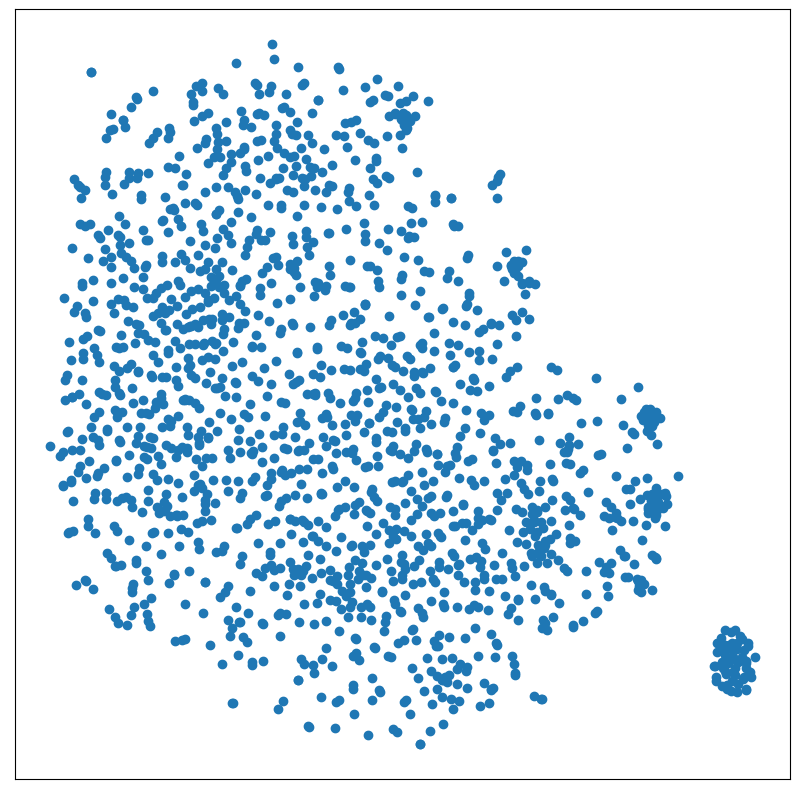

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

In [42]:
import plotly.express as px

tsne_df = pd.DataFrame(item_tsne, columns=["tsne_1", "tsne_2"])
tsne_df["item_id"] = np.arange(item_tsne.shape[0])
tsne_df = tsne_df.merge(items.reset_index())

px.scatter(tsne_df, x="tsne_1", y="tsne_2",
           color="popularity",
           hover_data=["item_id", "title", "popularity"])

### Exercises

 - Add another layer to the neural network and retrain, compare train/test error.
 - Try adding more dropout and change layer sizes.


In [43]:
'''from sklearn.model_selection import train_test_split
import numpy as np

# Split all ratings into training (80%) and temporary set (20%)
ratings_train, ratings_temp = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

# Split the temporary set into validation (50% of 20% = 10% overall) and test (50% of 20% = 10% overall)
ratings_val, ratings_test = train_test_split(
    ratings_temp, test_size=0.5, random_state=0)

# Extract arrays for training
user_id_train = np.array(ratings_train['user_id'])
item_id_train = np.array(ratings_train['item_id'])
rating_train = np.array(ratings_train['rating'])

# Extract arrays for validation
user_id_val = np.array(ratings_val['user_id'])
item_id_val = np.array(ratings_val['item_id'])
rating_val = np.array(ratings_val['rating'])

# Extract arrays for testing
user_id_test = np.array(ratings_test['user_id'])
item_id_test = np.array(ratings_test['item_id'])
rating_test = np.array(ratings_test['rating'])'''


"from sklearn.model_selection import train_test_split\nimport numpy as np\n\n# Split all ratings into training (80%) and temporary set (20%)\nratings_train, ratings_temp = train_test_split(\n    all_ratings, test_size=0.2, random_state=0)\n\n# Split the temporary set into validation (50% of 20% = 10% overall) and test (50% of 20% = 10% overall)\nratings_val, ratings_test = train_test_split(\n    ratings_temp, test_size=0.5, random_state=0)\n\n# Extract arrays for training\nuser_id_train = np.array(ratings_train['user_id'])\nitem_id_train = np.array(ratings_train['item_id'])\nrating_train = np.array(ratings_train['rating'])\n\n# Extract arrays for validation\nuser_id_val = np.array(ratings_val['user_id'])\nitem_id_val = np.array(ratings_val['item_id'])\nrating_val = np.array(ratings_val['rating'])\n\n# Extract arrays for testing\nuser_id_test = np.array(ratings_test['user_id'])\nitem_id_test = np.array(ratings_test['item_id'])\nrating_test = np.array(ratings_test['rating'])"

---

**1 - one hidden layer with hidden units = 32**

In [44]:
class ImprovedRegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, hidden_units=32):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_user_id + 1,
                                   input_length=1,
                                   name='user_embedding')
    self.item_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_item_id + 1,
                                   input_length=1,
                                   name='item_embedding')

    self.hidden1 = Dense(units=hidden_units, activation='relu')  # Hidden layer

    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.flatten(self.user_embedding(user_inputs))
    item_vecs = self.flatten(self.item_embedding(item_inputs))

    hidden = self.hidden1(user_vecs * item_vecs)  

    y = self.dot([hidden])
    return y

In [45]:
model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mse')  # You can use another loss function like 'mae'


Epoch 1/10
1125/1125 [==============================] - 2s 2ms/step - loss: 9.4883 - val_loss: 2.1710
Epoch 2/10
1125/1125 [==============================] - 2s 2ms/step - loss: 1.3257 - val_loss: 1.0665
Epoch 3/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.9373 - val_loss: 0.9491
Epoch 4/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8522 - val_loss: 0.9089
Epoch 5/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7998 - val_loss: 0.8987
Epoch 6/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7549 - val_loss: 0.8850
Epoch 7/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7106 - val_loss: 0.8867
Epoch 8/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.6627 - val_loss: 0.8818
Epoch 9/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6140 - val_loss: 0.8912
Epoch 10/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.563

Text(0.5, 1.0, 'Loss')

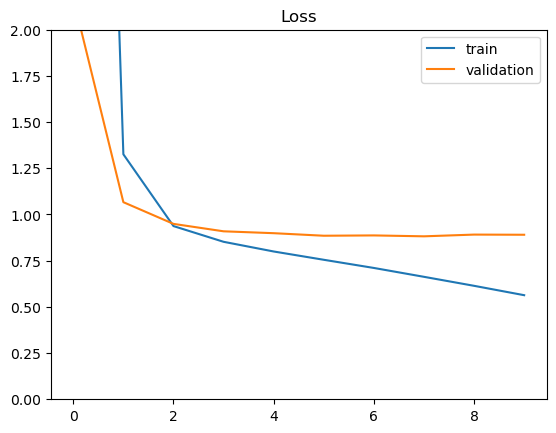

In [46]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 854us/step
Final test MSE: 0.883
Final test MAE: 0.734


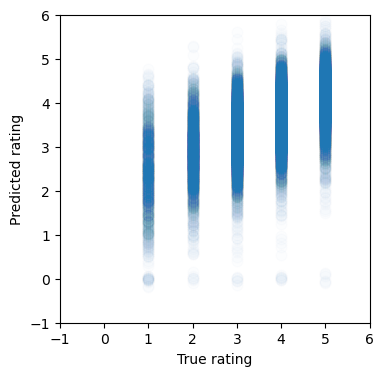

In [47]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**Conclusion: No overfitting and the model is learning**

---

**2 - one hidden layer with hidden units = 16**

In [48]:
class ImprovedRegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, hidden_units=16):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_user_id + 1,
                                   input_length=1,
                                   name='user_embedding')
    self.item_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_item_id + 1,
                                   input_length=1,
                                   name='item_embedding')

    self.hidden1 = Dense(units=hidden_units, activation='relu')  # Hidden layer

    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.flatten(self.user_embedding(user_inputs))
    item_vecs = self.flatten(self.item_embedding(item_inputs))

    hidden = self.hidden1(user_vecs * item_vecs)  

    y = self.dot([hidden])
    return y
  
  
  
model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mse')  # You can use another loss function like 'mae'

Epoch 1/10
1125/1125 [==============================] - 3s 2ms/step - loss: 9.6775 - val_loss: 2.2303
Epoch 2/10
1125/1125 [==============================] - 3s 2ms/step - loss: 1.3343 - val_loss: 1.0654
Epoch 3/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.9327 - val_loss: 0.9589
Epoch 4/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8525 - val_loss: 0.9154
Epoch 5/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.8035 - val_loss: 0.8944
Epoch 6/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7593 - val_loss: 0.8820
Epoch 7/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7145 - val_loss: 0.8842
Epoch 8/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6674 - val_loss: 0.8788
Epoch 9/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.6189 - val_loss: 0.8779
Epoch 10/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.563

Text(0.5, 1.0, 'Loss')

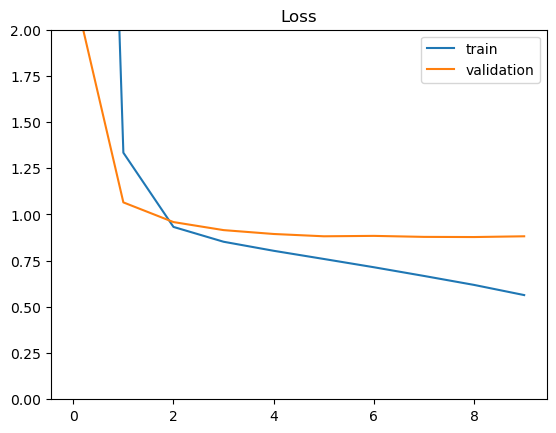

In [49]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 950us/step
Final test MSE: 0.872
Final test MAE: 0.728


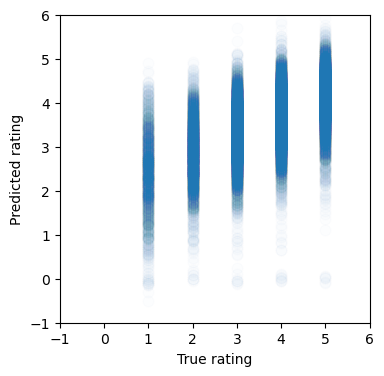

In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**Conclusion: No overfitting and the model is learning**

---

**3 - one hidden layer with hidden units = 128**

In [51]:
class ImprovedRegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, hidden_units=128):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_user_id + 1,
                                   input_length=1,
                                   name='user_embedding')
    self.item_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_item_id + 1,
                                   input_length=1,
                                   name='item_embedding')

    self.hidden1 = Dense(units=hidden_units, activation='relu')  # Hidden layer

    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.flatten(self.user_embedding(user_inputs))
    item_vecs = self.flatten(self.item_embedding(item_inputs))

    hidden = self.hidden1(user_vecs * item_vecs)  

    y = self.dot([hidden])
    return y
  
  
  
model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mse')  # You can use another loss function like 'mae'

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 9.4302 - val_loss: 2.1572
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.3228 - val_loss: 1.0735
Epoch 3/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.9445 - val_loss: 0.9653
Epoch 4/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8685 - val_loss: 0.9176
Epoch 5/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.8124 - val_loss: 0.8996
Epoch 6/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.7644 - val_loss: 0.8854
Epoch 7/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.7166 - val_loss: 0.8839
Epoch 8/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.6706 - val_loss: 0.8783
Epoch 9/10
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6226 - val_loss: 0.8841
Epoch 10/10
1125/1125 [==============================] - 3s 2ms/step - loss: 0.571

Text(0.5, 1.0, 'Loss')

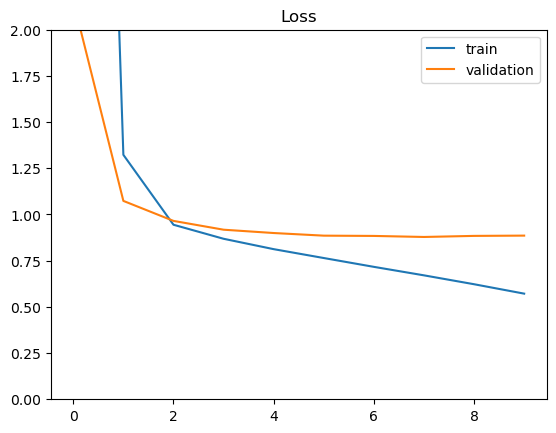

In [52]:


%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 1ms/step
Final test MSE: 0.879
Final test MAE: 0.733


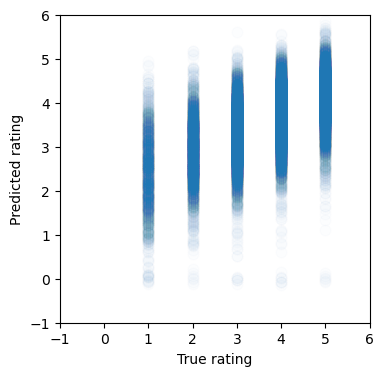

In [53]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)

test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**Conclusion: No overfitting and the model is learning**

---

**4 - Dropout layers with dropout rate = 0.2 after the embedding layers**

In [54]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id, dropout_rate=0.2):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding',
                                        embeddings_regularizer=regularizers.l2(0.01))
        self.dropout1 = Dropout(dropout_rate)

        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding',
                                        embeddings_regularizer=regularizers.l2(0.01))
        self.dropout2 = Dropout(dropout_rate)

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.dropout1(self.flatten(self.user_embedding(user_inputs)))
        item_vecs = self.dropout2(self.flatten(self.item_embedding(item_inputs)))

        y = self.dot([user_vecs, item_vecs])
        return y

# Set the desired dropout rate
dropout_rate = 0.2

model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max(), dropout_rate=dropout_rate)
model.compile(optimizer="adam", loss='mae')

Epoch 1/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5462 - val_loss: 3.5280
Epoch 2/10
1125/1125 [==============================] - 2s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 3/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 4/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 5/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 6/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 7/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 8/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 9/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 10/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.528

Text(0.5, 1.0, 'Loss')

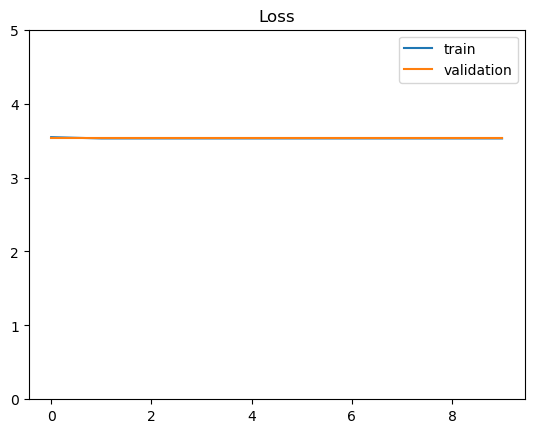

In [55]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 1ms/step
Final test MSE: 13.757
Final test MAE: 3.535


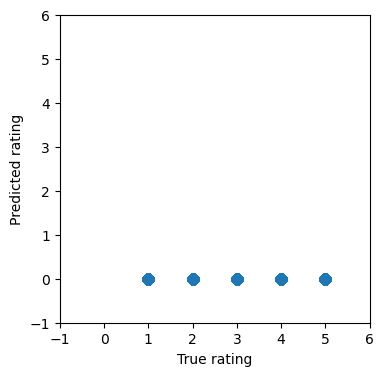

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**onclusion: The model is underfitting because both training and validation losses are high and show no significant improvement, and this indicates that the model is not able to learn the patterns in the data effectively.**

---

**5 - Dropout layers with dropout rate = 0.2 after the embedding layers**

In [57]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id, dropout_rate=0.1):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding',
                                        embeddings_regularizer=regularizers.l2(0.01))
        self.dropout1 = Dropout(dropout_rate)

        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding',
                                        embeddings_regularizer=regularizers.l2(0.01))
        self.dropout2 = Dropout(dropout_rate)

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.dropout1(self.flatten(self.user_embedding(user_inputs)))
        item_vecs = self.dropout2(self.flatten(self.item_embedding(item_inputs)))

        y = self.dot([user_vecs, item_vecs])
        return y

# Set the desired dropout rate
dropout_rate = 0.1

model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max(), dropout_rate=dropout_rate)
model.compile(optimizer="adam", loss='mae')

Epoch 1/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5462 - val_loss: 3.5280
Epoch 2/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 3/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 5/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 6/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 7/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 8/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 9/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 10/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.528

Text(0.5, 1.0, 'Loss')

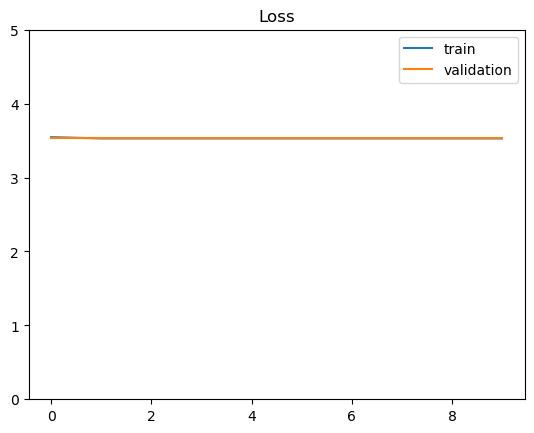

In [58]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 1ms/step
Final test MSE: 13.757
Final test MAE: 3.535


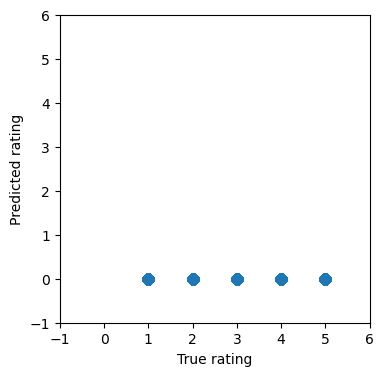

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**onclusion: The model is underfitting because both training and validation losses are high and show no significant improvement, and this indicates that the model is not able to learn the patterns in the data effectively.**

---

**6 - Dropout layers with dropout rate = 0.1 after the embedding layers and 2 hiiden layers**

In [60]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout, Dense

class RegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, dropout_rate=0.1, hidden_units=[128, 64]):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                     input_dim=max_user_id + 1,
                                     input_length=1,
                                     name='user_embedding',
                                     embeddings_regularizer=regularizers.l2(0.01))
    self.dropout1 = Dropout(dropout_rate)

    self.item_embedding = Embedding(output_dim=embedding_size,
                                     input_dim=max_item_id + 1,
                                     input_length=1,
                                     name='item_embedding',
                                     embeddings_regularizer=regularizers.l2(0.01))
    self.dropout2 = Dropout(dropout_rate)

    # Hidden layers with activation function (e.g., ReLU)
    self.hidden1 = Dense(units=hidden_units[0], activation='relu')
    self.hidden2 = Dense(units=hidden_units[1], activation='relu')

    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.dropout1(self.flatten(self.user_embedding(user_inputs)))
    item_vecs = self.dropout2(self.flatten(self.item_embedding(item_inputs)))

    # Pass through hidden layers
    user_vecs = self.hidden1(user_vecs)
    user_vecs = self.hidden2(user_vecs)

    y = self.dot([user_vecs, item_vecs])
    return y

# Set desired dropout rate and hidden layer configuration
dropout_rate = 0.1
hidden_units = [128, 64]  # Example configuration with 2 layers

model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max(), dropout_rate=dropout_rate, hidden_units=hidden_units)
model.compile(optimizer="adam", loss='mae')

Epoch 1/10
1125/1125 [==============================] - 5s 3ms/step - loss: 1.5045 - val_loss: 1.1637
Epoch 2/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.1635 - val_loss: 1.1331
Epoch 3/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.1415 - val_loss: 1.1247
Epoch 4/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.1287 - val_loss: 1.0972
Epoch 5/10
1125/1125 [==============================] - 5s 4ms/step - loss: 1.1162 - val_loss: 1.0806
Epoch 6/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.1081 - val_loss: 1.0928
Epoch 7/10
1125/1125 [==============================] - 5s 4ms/step - loss: 1.0990 - val_loss: 1.0633
Epoch 8/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.0958 - val_loss: 1.0402
Epoch 9/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.0866 - val_loss: 1.0440
Epoch 10/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.084

Text(0.5, 1.0, 'Loss')

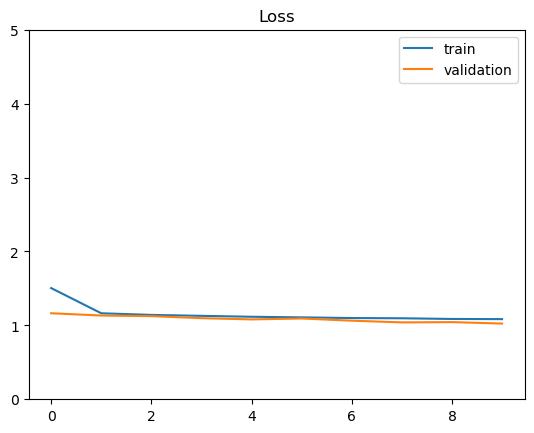

In [61]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 1ms/step
Final test MSE: 1.280
Final test MAE: 0.884


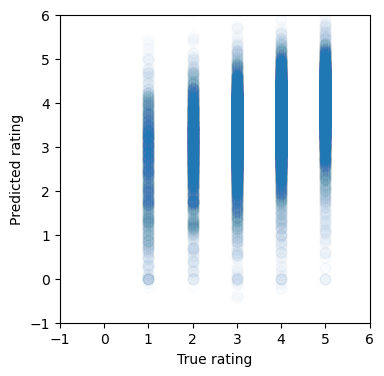

In [62]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

---

**7 - Using L2 penalty on weights**

In [63]:
from tensorflow.keras import regularizers

class RegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, l2_reg=0.01):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                    input_dim=max_user_id + 1,
                                    input_length=1,
                                    name='user_embedding',
                                    embeddings_regularizer=regularizers.l2(l2_reg))  # Add L2 regularization

    self.item_embedding = Embedding(output_dim=embedding_size,
                                    input_dim=max_item_id + 1,
                                    input_length=1,
                                    name='item_embedding',
                                    embeddings_regularizer=regularizers.l2(l2_reg))  # Add L2 regularization

    # The following two layers don't have parameters.
    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.flatten(self.user_embedding(user_inputs))
    item_vecs = self.flatten(self.item_embedding(item_inputs))

    y = self.dot([user_vecs, item_vecs])
    return y

# Set the desired L2 regularization weight
l2_reg = 0.01

model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max(), l2_reg=l2_reg)
model.compile(optimizer="adam", loss='mae')

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 3.5462 - val_loss: 3.5280
Epoch 2/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 3/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 4/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 5/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 6/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 7/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 8/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 9/10
1125/1125 [==============================] - 3s 3ms/step - loss: 3.5286 - val_loss: 3.5280
Epoch 10/10
1125/1125 [==============================] - 3s 2ms/step - loss: 3.528

Text(0.5, 1.0, 'Loss')

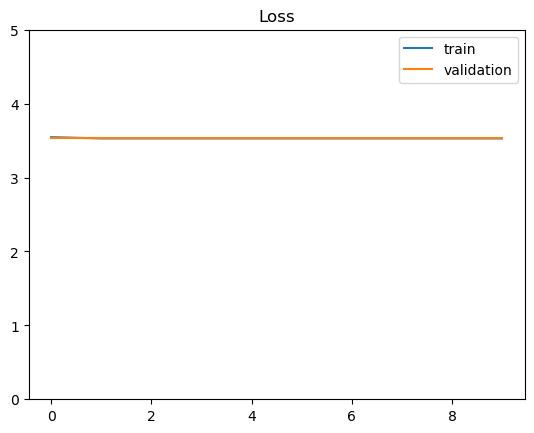

In [64]:
%%time

# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 1ms/step
Final test MSE: 13.757
Final test MAE: 3.535


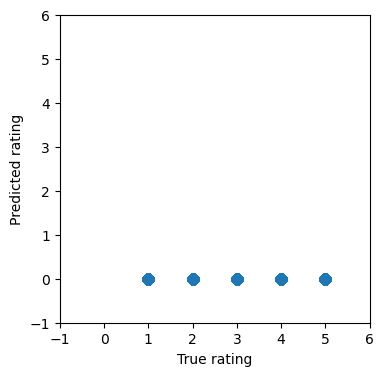

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

**Conclusion: The model is underfitting because both training and validation losses are high and show no significant improvement, and this indicates that the model is not able to learn the patterns in the data effectively.**

---

### A recommendation function for a given user

Once the model is trained, the system can be used to recommend a few items for a user that they haven't seen before. The following code does that.

- we use the `model.predict` to compute the ratings a user would have given to all items
- we build a function that sorts these items and excludes those the user has already seen.

In [66]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [67]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 [==============================] - 0s 2ms/step
    0.0: Burnt Offerings (1976)
    0.0: Victor/Victoria (1982)
    0.0: Young Guns (1988)
    0.0: Beyond Bedlam (1993)
    0.0: Long Kiss Goodnight, The (1996)
    0.0: Big Bang Theory, The (1994)
    0.0: Godfather: Part II, The (1974)
    0.0: Tin Men (1987)
    0.0: D3: The Mighty Ducks (1996)
    0.0: Crying Game, The (1992)


**These are the recommendations of case 7 which used L2 penalty on weights and it was underfitting**

---

### Exercises

- Try modifying our neural network to improve recommendation. You could try adding more layers, or using a different loss function. 
- Your goal is to improve the Mean Absolute Error on the test set. Show the results of your best model.

**This s for the unmodified code**

In [68]:
# Extend and improve the model below
class RegressionModel(Model):
    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_user_id + 1,
                                        input_length=1,
                                        name='user_embedding')
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=max_item_id + 1,
                                        input_length=1,
                                        name='item_embedding')

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.dot = Dot(axes=1)

    def call(self, inputs):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        y = self.dot([user_vecs, item_vecs])
        return y


model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mae')

In [69]:
# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=10, validation_split=0.1,
                    shuffle=True)

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 2.6582 - val_loss: 1.0599
Epoch 2/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.8506 - val_loss: 0.7928
Epoch 3/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7545 - val_loss: 0.7701
Epoch 4/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7284 - val_loss: 0.7579
Epoch 5/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.7074 - val_loss: 0.7472
Epoch 6/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6843 - val_loss: 0.7442
Epoch 7/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6623 - val_loss: 0.7391
Epoch 8/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6386 - val_loss: 0.7387
Epoch 9/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.6150 - val_loss: 0.7351
Epoch 10/10
1125/1125 [==============================] - 3s 3ms/step - loss: 0.590

In [70]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [71]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 [==============================] - 0s 1ms/step
    4.9: Dead Man Walking (1995)
    4.7: 20,000 Leagues Under the Sea (1954)
    4.6: Faster Pussycat! Kill! Kill! (1965)
    4.6: Affair to Remember, An (1957)
    4.6: Letter From Death Row, A (1998)
    4.6: Eat Drink Man Woman (1994)
    4.6: Godfather: Part II, The (1974)
    4.4: Celtic Pride (1996)
    4.4: Rock, The (1996)
    4.3: Wrong Trousers, The (1993)


---

**I chose from the above seven cases the one with added one hidden layer with hidden units = 32**, and icreased the epochs number to 15.

In [142]:
class ImprovedRegressionModel(Model):
  def __init__(self, embedding_size, max_user_id, max_item_id, hidden_units=32):
    super().__init__()

    self.user_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_user_id + 1,
                                   input_length=1,
                                   name='user_embedding')
    self.item_embedding = Embedding(output_dim=embedding_size,
                                   input_dim=max_item_id + 1,
                                   input_length=1,
                                   name='item_embedding')

    self.hidden1 = Dense(units=hidden_units, activation='relu')  # Hidden layer

    self.flatten = Flatten()
    self.dot = Dot(axes=1)

  def call(self, inputs):
    user_inputs = inputs[0]
    item_inputs = inputs[1]

    user_vecs = self.flatten(self.user_embedding(user_inputs))
    item_vecs = self.flatten(self.item_embedding(item_inputs))

    hidden = self.hidden1(user_vecs * item_vecs)  

    y = self.dot([hidden])
    return y
  
  
  
model = RegressionModel(embedding_size=64, max_user_id=all_ratings['user_id'].max(), max_item_id=all_ratings['item_id'].max())
model.compile(optimizer="adam", loss='mse')  # You can use another loss function like 'mae'

In [137]:
# Training the model
history = model.fit([user_id_train, item_id_train], rating_train,
                    batch_size=64, epochs=15, validation_split=0.1,
                    shuffle=True)

Epoch 1/15
1125/1125 [==============================] - 5s 4ms/step - loss: 9.5025 - val_loss: 2.1250
Epoch 2/15
1125/1125 [==============================] - 2s 2ms/step - loss: 1.3157 - val_loss: 1.0689
Epoch 3/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.9497 - val_loss: 0.9760
Epoch 4/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8799 - val_loss: 0.9363
Epoch 5/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.8294 - val_loss: 0.9113
Epoch 6/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7827 - val_loss: 0.8939
Epoch 7/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.7337 - val_loss: 0.8827
Epoch 8/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6851 - val_loss: 0.8905
Epoch 9/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.6348 - val_loss: 0.8869
Epoch 10/15
1125/1125 [==============================] - 2s 2ms/step - loss: 0.583

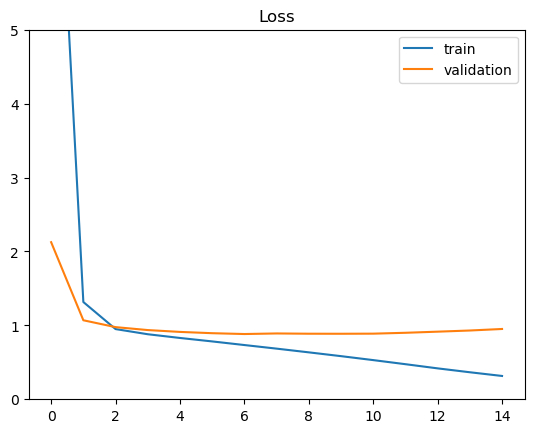

In [138]:


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 5)
plt.legend(loc='best')
plt.title('Loss');

625/625 [==============================] - 1s 797us/step
Final test MSE: 0.944
Final test MAE: 0.758


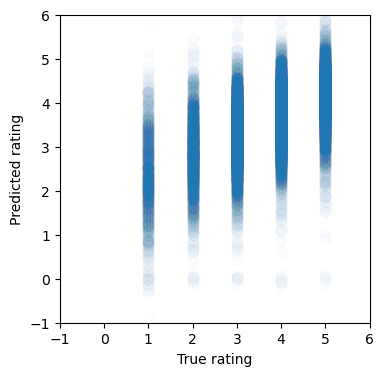

In [139]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(4, 4))
    plt.xlim(-1, 6)
    plt.xlabel("True rating")
    plt.ylim(-1, 6)
    plt.ylabel("Predicted rating")
    plt.scatter(y_true, y_pred, s=60, alpha=0.01)
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))
plot_predictions(rating_test, test_preds)

In [140]:
def recommend(user_id, top_n=10):
    item_ids = range(1, items['item_id'].max())
    seen_mask = all_ratings["user_id"] == user_id
    seen_movies = set(all_ratings[seen_mask]["item_id"])
    item_ids = list(filter(lambda x: x not in seen_movies, item_ids))

    user = np.zeros_like(item_ids)
    user[:len(item_ids)] = user_id
    items_ = np.array(item_ids)
    ratings = model.predict([user, items_]).flatten()
    top_items = ratings.argsort()[-top_n:][::-1]
    return [(indexed_items.loc[item_id]["title"], ratings[item_id]) for item_id in top_items]

In [141]:
for title, pred_rating in recommend(5):
    print("    %0.1f: %s" % (pred_rating, title))

48/48 [==============================] - 0s 934us/step
    4.9: Get Shorty (1995)
    4.6: Star Trek: First Contact (1996)
    4.6: Sunset Blvd. (1950)
    4.6: Clockwork Orange, A (1971)
    4.5: Faster Pussycat! Kill! Kill! (1965)
    4.5: Celtic Pride (1996)
    4.5: Mr. Holland's Opus (1995)
    4.5: Mouse Hunt (1997)
    4.4: Supercop (1992)
    4.4: Young Guns (1988)
